In [1]:
# avoid decoding problems
import re
import nltk
import gensim
import pandas as pd
from tqdm import tqdm
from TextSim import TextSim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec

In [2]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [16]:
# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


In [4]:
df = pd.read_csv("Precily_Text_Similarity.csv")

In [5]:
df["text1_clean"] = df["text1"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=nltk.corpus.stopwords.words("english")))
df["text2_clean"] = df["text2"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=nltk.corpus.stopwords.words("english")))

In [6]:
texts = list(df['text1_clean']) + list(df['text2_clean'])

# tokenize
c = 0
for text in tqdm(texts):
    texts[c] = list(gensim.utils.tokenize(text, deacc=True, lower=True))
    c += 1

100%|██████████| 6000/6000 [00:03<00:00, 1917.63it/s]


In [25]:
# train model
model = gensim.models.Word2Vec(texts, vector_size=300,window=10,min_count=1,epochs=100,negative=20,sample=1e-4,callbacks=[callback()],compute_loss=True)

# model.save('3_word2vec.mdl')
model.wv.save_word2vec_format('model.bin',binary=True)


Loss after epoch 0: 1519172.5
Loss after epoch 1: 991213.0
Loss after epoch 2: 867211.75
Loss after epoch 3: 856143.75
Loss after epoch 4: 652364.0
Loss after epoch 5: 581310.0
Loss after epoch 6: 499791.0
Loss after epoch 7: 476412.0
Loss after epoch 8: 415636.5
Loss after epoch 9: 377821.5
Loss after epoch 10: 360364.5
Loss after epoch 11: 350089.5
Loss after epoch 12: 337572.0
Loss after epoch 13: 309802.0
Loss after epoch 14: 293041.0
Loss after epoch 15: 289798.0
Loss after epoch 16: 300948.0
Loss after epoch 17: 290864.0
Loss after epoch 18: 302388.0
Loss after epoch 19: 296770.0
Loss after epoch 20: 291051.0
Loss after epoch 21: 310113.0
Loss after epoch 22: 307038.0
Loss after epoch 23: 298763.0
Loss after epoch 24: 307952.0
Loss after epoch 25: 296160.0
Loss after epoch 26: 302301.0
Loss after epoch 27: 316860.0
Loss after epoch 28: 318466.0
Loss after epoch 29: 312512.0
Loss after epoch 30: 308969.0
Loss after epoch 31: 309421.0
Loss after epoch 32: 327829.0
Loss after epoch 

In [26]:
model_path = 'model.bin'
w2v_model = KeyedVectors.load_word2vec_format(model_path,binary=True)
ds = DocSim(w2v_model)

In [27]:
for i in range(100):
    s1 = df['text1'][i]
    s2 = df['text2'][i]
    print(ds.calculate_similarity(s1, s2),i)

[{'score': '0.23740047'}] 0
[{'score': '0.109546386'}] 1
[{'score': '0.20133021'}] 2
[{'score': '0.16100597'}] 3
[{'score': '0.32331446'}] 4
[{'score': '0.24365297'}] 5
[{'score': '0.061758827'}] 6
[{'score': '0.24758576'}] 7
[{'score': 0.0}] 8
[{'score': '0.18082073'}] 9
[{'score': '0.19594179'}] 10
[{'score': '0.27479747'}] 11
[{'score': '0.4760585'}] 12
[{'score': '0.39846483'}] 13
[{'score': '0.11522041'}] 14
[{'score': 0.0}] 15
[{'score': '0.54431283'}] 16
[{'score': '0.7076448'}] 17
[{'score': '0.34646872'}] 18
[{'score': '0.17772298'}] 19
[{'score': '0.15980387'}] 20
[{'score': '0.16465975'}] 21
[{'score': '0.18166575'}] 22
[{'score': 0.0}] 23
[{'score': '0.4532303'}] 24
[{'score': '0.20813097'}] 25
[{'score': '0.14717734'}] 26
[{'score': 0.0}] 27
[{'score': '0.15352903'}] 28
[{'score': '0.09331119'}] 29
[{'score': '0.18699458'}] 30
[{'score': '0.29839933'}] 31
[{'score': '0.52299136'}] 32
[{'score': '0.18528597'}] 33
[{'score': '0.2151036'}] 34
[{'score': '0.32729214'}] 35
[{'s

d:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\Python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
d:\Python\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Darke\AppData\Local\Temp/ipykernel_23112/1348732182.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warni

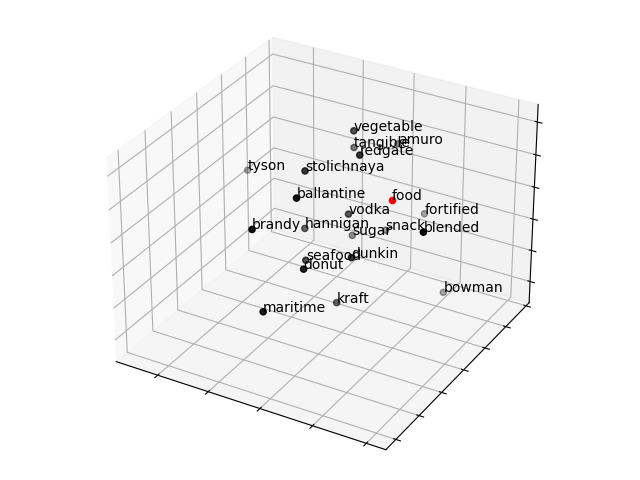

In [30]:
import matplotlib.pyplot as plt
from sklearn import manifold
%matplotlib widget
nlp = w2v_model

word = "food"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D

ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)